# 서울시 주요 공원현황 자료 분석및 비교

In [38]:
import time
import pandas as pd
import numpy as np
import re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook
from glob import glob
import seaborn as sns
import json
import folium
import warnings
import requests
from urllib.parse import urlparse, quote
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import googlemaps
warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline
mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)

## 데이터 정리

In [39]:
park = pd.read_csv('./data/서울시 주요 공원현황.csv',encoding='euc-kr')
park.head()
park2 = park[['공원명','면적','지역','공원주소','X좌표(WGS84)','Y좌표(WGS84)']]


### 면적부분이 복잡해서 숫자만 뽑아냈습니다

In [40]:
park_size = []
for i in park2['면적']:
    if type(i) == str:
        if i.split()[0] == '총':
            park_size.append(i.split()[1])
        elif i.split()[0] == '휴양':
            park_size.append('')
        else:
            park_size.append(i.split()[0])
    else:
        print(i)
        park_size.append('')
park_size2 = []
for i in park_size:
    k = [float(i) for i in re.findall(r"[-+]?\d*\.\d+|\d+", i)]
    try:
        if k[1]:
            k = k[0]
    except:
        pass
    park_size2.append(k)
park_size2


nan
nan
nan


[[2896887.0],
 [80683.0],
 [9132690.0],
 [480994.0],
 [2284085.0],
 [8948.1],
 [],
 [6456.0],
 [80309.0],
 [1980.4],
 [5197.7],
 [11467.0],
 [229539.0],
 [15179.7],
 [16734.6],
 [61544.0],
 [424106.0],
 [560552.0],
 [26696.8],
 [75900.0],
 113021.7,
 [201779.0],
 [258991.0],
 [10420819.08],
 [171294.1],
 [15000.0],
 [297926.0],
 [411972.0],
 [98470.0],
 [2038741.3],
 [603715.2],
 [108120.0],
 [29619.3],
 [29843.8],
 [126026.0],
 [135002.7],
 [384026.0],
 [180000.0],
 [416031.0],
 [160720.0],
 [2277252.0],
 [19599.7],
 [138596.0],
 [185295.0],
 [254648.0],
 [29816.5],
 [762642.0],
 [664905.0],
 [99599.9],
 [5802.0],
 [16500.0],
 [585652.0],
 [649709.6],
 [72132.0],
 [66027.8],
 [265582.0],
 [2088704.9],
 [112070.0],
 [993724.0],
 [219167.0],
 [1349556.4],
 [1511198.0],
 [1097565.0],
 [328018.0],
 [1447122.0],
 [207790.0],
 [1018689.0],
 [954553.0],
 [1667848.0],
 [13224.0],
 [130345.0],
 [5332422.0],
 [5107964.0],
 [47832.0],
 [213552.0],
 [168099.87],
 [359435.2],
 [36660.0],
 [380735.

In [41]:
park_size = []
for i in park_size2:
    try:
       park_size.append(i[0])
    except:
        park_size.append('')
park_size[:5]

[2896887.0, 80683.0, 9132690.0, 480994.0, 2284085.0]

In [42]:
pd.options.display.float_format = '{:.2f}'.format # 지수형을 실수형으로
park2['면적'] = park_size
park2.tail()

,공원명,면적,지역,공원주소,X좌표(WGS84),Y좌표(WGS84)
127,용마도시자연공원(사가정공원),109635.00,중랑구,서울특별시 중랑구 면목7동 산50,127.10,37.58
128,문화비축기지,140022.00,마포구,서울특별시 마포구 증산로 87,126.89,37.57
129,경춘선숲길,211392.00,NaN,노원구 공릉2동 산 82-2,127.08,37.63
130,율현공원,157535.00,강남구,서울특별시 강남구 율현동 밤고개로24길(율현동 56),127.12,37.47
131,서울로7017,,중구,서울로7017,nan,nan


In [43]:
park2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   공원명         132 non-null    object 
 1   면적          132 non-null    object 
 2   지역          131 non-null    object 
 3   공원주소        132 non-null    object 
 4   X좌표(WGS84)  131 non-null    float64
 5   Y좌표(WGS84)  131 non-null    float64
dtypes: float64(2), object(4)
memory usage: 6.3+ KB


### 혹시 몰라서 구주소도 넣었습니다

In [44]:
key_fd = open('./data/kmap_key.txt')
kmap_key = key_fd.read(100)
key_fd.close()
old_addr = []
for i in park2.index:
    try:
        url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + park2['공원주소'][i] 
        result = requests.get(urlparse(url).geturl(), headers={"Authorization":"KakaoAK "+ kmap_key}).json()
        address = result['documents'][0]['address']['address_name']
        old_addr.append(address)
    except:
        try:
            url = f"https://dapi.kakao.com/v2/local/geo/coord2address.json?x={park2['X좌표(WGS84)'][i]}&y={park2['Y좌표(WGS84)'][i]}"
            result = requests.get(urlparse(url).geturl(), headers={"Authorization":"KakaoAK "+ kmap_key}).json()
            address = result['documents'][0]['address']['address_name']
            old_addr.append(address)
        except:
            old_addr.append('')

In [45]:
park2['구주소'] = old_addr

In [46]:
park2.drop([131],inplace=True)
park2.tail()

,공원명,면적,지역,공원주소,X좌표(WGS84),Y좌표(WGS84),구주소
126,서일대뒷산공원,631021.00,중랑구,서울특별시 중랑구 면목동 산19,127.10,37.59,서울 중랑구 면목동 산 19
127,용마도시자연공원(사가정공원),109635.00,중랑구,서울특별시 중랑구 면목7동 산50,127.10,37.58,서울 중랑구 면목동 산 50-23
128,문화비축기지,140022.00,마포구,서울특별시 마포구 증산로 87,126.89,37.57,서울 마포구 성산동 670
129,경춘선숲길,211392.00,NaN,노원구 공릉2동 산 82-2,127.08,37.63,서울 노원구 공릉동 425-5
130,율현공원,157535.00,강남구,서울특별시 강남구 율현동 밤고개로24길(율현동 56),127.12,37.47,서울 강남구 율현동 300-42


In [47]:
park2 = park2[park2['구주소'].str.contains('서울')]

In [48]:
park2['면적'] = park2['면적'].apply(pd.to_numeric)

In [49]:
type(park2['지역'][129])

float

In [51]:
for i in park2.index:
    if pd.isna(park2['지역'][i]):
        park2['지역'][i] = park2['구주소'][i].split()[1]

park2.tail()


,공원명,면적,지역,공원주소,X좌표(WGS84),Y좌표(WGS84),구주소
126,서일대뒷산공원,631021.00,중랑구,서울특별시 중랑구 면목동 산19,127.10,37.59,서울 중랑구 면목동 산 19
127,용마도시자연공원(사가정공원),109635.00,중랑구,서울특별시 중랑구 면목7동 산50,127.10,37.58,서울 중랑구 면목동 산 50-23
128,문화비축기지,140022.00,마포구,서울특별시 마포구 증산로 87,126.89,37.57,서울 마포구 성산동 670
129,경춘선숲길,211392.00,노원구,노원구 공릉2동 산 82-2,127.08,37.63,서울 노원구 공릉동 425-5
130,율현공원,157535.00,강남구,서울특별시 강남구 율현동 밤고개로24길(율현동 56),127.12,37.47,서울 강남구 율현동 300-42


In [14]:
gu_area = pd.read_csv("./data/구 면적.txt",sep = "\t", engine='python',encoding='utf-8',thousands = ',')
gu_area.head()

,기간,자치구,면적,면적.1,동,동.1,통,반
0,기간,자치구,면적,구성비(%),행정,법정,통,반
1,2019,서울시,605.24,100,424,467,12713,94152
2,2019,종로구,23.91,4,17,87,278,1479
3,2019,중구,9.96,1.6,15,74,253,1580
4,2019,용산구,21.87,3.6,16,36,351,2550


In [15]:
gu_area2 = gu_area[['자치구','면적']][2:]
gu_area2 = gu_area2.rename(columns={'자치구':'지역'})
gu_area2.head()

,지역,면적
2,종로구,23.91
3,중구,9.96
4,용산구,21.87
5,성동구,16.86
6,광진구,17.06


In [16]:
park2_group = park2.groupby('지역').count()[['공원명']]
gu_park_count = pd.merge(gu_area2,park2_group,on='지역')
gu_park_count = gu_park_count.rename(columns={'공원명':'공원수'})
gu_park_count['면적'] = gu_park_count['면적'].apply(pd.to_numeric)
gu_park_count.head()

,지역,면적,공원수
0,종로구,23.91,12
1,중구,9.96,4
2,용산구,21.87,2
3,성동구,16.86,5
4,광진구,17.06,2


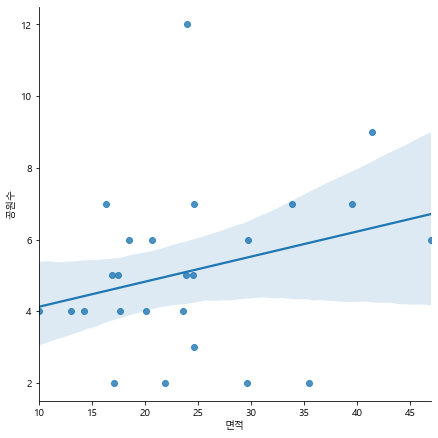

In [17]:
sns.lmplot(data = gu_park_count,x='면적',y='공원수',size=6)
# 면적대비 공원수가 어느정도 비례


In [18]:
park_area = park2.groupby('지역').sum()[['면적']].rename(columns={'면적':'공원면적'})

In [19]:
gu_park_area = pd.merge(park_area,gu_area2,on='지역')
gu_park_area['면적'] = gu_park_area['면적'].apply(pd.to_numeric) * 10**6
gu_park_area['면적대비 공원면적 비율'] = gu_park_area['공원면적'] / gu_park_area['면적'] * 100
gu_park_area_sort = gu_park_area.sort_values(by='면적대비 공원면적 비율',ascending=False)
gu_park_area_sort.head()


,지역,공원면적,면적,면적대비 공원면적 비율
24,중랑구,7078975.00,18500000.00,38.26
4,관악구,10431453.08,29570000.00,35.28
8,노원구,12024307.30,35440000.00,33.93
23,중구,2943303.80,9960000.00,29.55
14,서초구,13359636.00,46980000.00,28.44


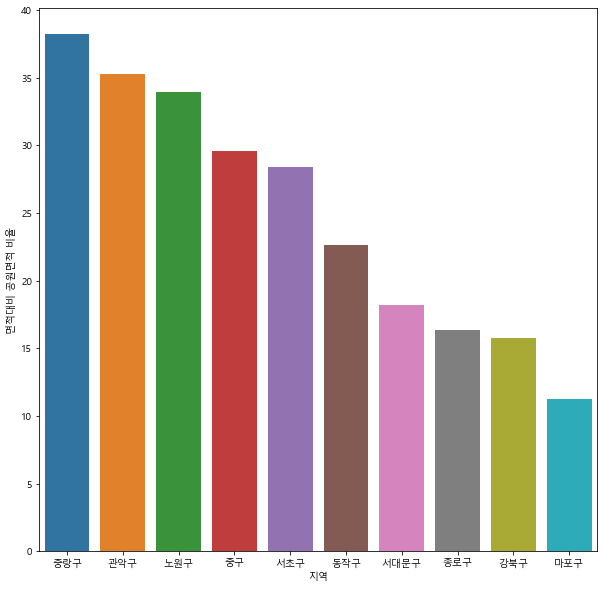

In [20]:
plt.figure(figsize=(10,10))
sns.barplot(data=gu_park_area_sort.head(10),y='면적대비 공원면적 비율',x='지역')
plt.show()

In [21]:
result = pd.merge(gu_park_area,park2_group,on='지역').rename(columns={'공원명':'공원수'})
result.head()

,지역,공원면적,면적,면적대비 공원면적 비율,공원수
0,강남구,3626398.50,39500000.00,9.18,7
1,강동구,1526389.30,24590000.00,6.21,7
2,강북구,3714902.40,23600000.00,15.74,4
3,강서구,2194154.10,41440000.00,5.29,9
4,관악구,10431453.08,29570000.00,35.28,2


In [22]:
pop = pd.read_csv("./data/02.pop_result.csv").rename(columns={'구별':'지역'})
pop.head()


,지역,인구수,한국인,외국인,고령자,외국인비율,고령자비율,일반가구수,1인,2인,3인,4인,1인 가구 비율,5인이상,인구수대비 1인 오차,고령자와 5인이상 오차,1인가구와 외국인 오차
0,구로구,435751,405579,30172,69312,6.92,15.91,156235,44151,41836,34633,27310,28.26,8305,8594.50,230.20,4.92
1,영등포구,405982,375630,30352,60826,7.48,14.98,149831,53477,37774,29904,22271,35.69,6405,3554.61,934.08,3.72
2,관악구,514555,498574,15981,78206,3.11,15.20,236761,112733,54106,35925,25997,47.61,8000,52514.21,1788.82,3.46
3,금천구,249641,232157,17484,39361,7.00,15.77,96298,34564,24305,18948,14102,35.89,4379,531.97,65.46,3.20
4,중구,135321,125800,9521,24265,7.04,17.93,53102,20803,14101,9601,6463,39.18,2134,3451.56,51.73,2.46


In [23]:
pop[['지역','인구수']]

,지역,인구수
0,구로구,435751
1,영등포구,405982
2,관악구,514555
3,금천구,249641
4,중구,135321
5,용산구,244953
6,강북구,313550
7,강남구,544085
8,강서구,589536
9,종로구,159842


In [24]:
result = pd.merge(result,pop[['지역','인구수']],on='지역')
result

,지역,공원면적,면적,면적대비 공원면적 비율,공원수,인구수
0,강남구,3626398.50,39500000.00,9.18,7,544085
1,강동구,1526389.30,24590000.00,6.21,7,462275
2,강북구,3714902.40,23600000.00,15.74,4,313550
3,강서구,2194154.10,41440000.00,5.29,9,589536
4,관악구,10431453.08,29570000.00,35.28,2,514555
5,광진구,584002.00,17060000.00,3.42,2,361923
6,구로구,1617657.00,20120000.00,8.04,4,435751
7,금천구,57568.00,13020000.00,0.44,4,249641
8,노원구,12024307.30,35440000.00,33.93,2,529532
9,도봉구,1084218.00,20660000.00,5.25,6,329300


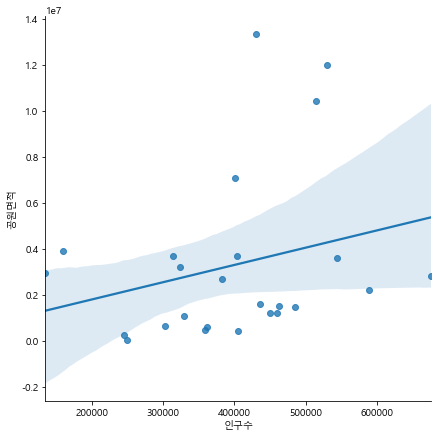

In [25]:
sns.lmplot(data = result,x='인구수',y='공원면적',size=6)
plt.show()

In [26]:
geo_path = './data/02. skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='UTF-8'))